In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:
X_train = pd.read_parquet("train.parquet")
X_test = pd.read_parquet("test.parquet")
#X


In [3]:
X_train.shape

(100000, 20)

In [4]:
def get_pickup_period_1(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon_part1'
    elif 16 <= hour <20:
        return 'Afternoon_part2'
    elif 20 <= hour <=23.99:
        return 'Evening'
    else:
        return 'Night'

In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

def transform_data(X, le):


    
    # Transformation de 'RatecodeID'
    X['RatecodeID'] = X['RatecodeID'].replace({99: 6})

    X['store_and_fwd_flag']=le.fit_transform(X['store_and_fwd_flag'])
    
    # Conversion des colonnes datetime
    X['tpep_pickup_datetime'] = pd.to_datetime(X['tpep_pickup_datetime'])
    X['tpep_dropoff_datetime'] = pd.to_datetime(X['tpep_dropoff_datetime'])
    
    # Extraction des jours et des heures
    X['pickup_day'] = X['tpep_pickup_datetime'].dt.day
    X['dropoff_day'] = X['tpep_dropoff_datetime'].dt.day
    X['pickup_hour'] = X['tpep_pickup_datetime'].dt.hour + X['tpep_pickup_datetime'].dt.minute / 60
    X['dropoff_hour'] = X['tpep_dropoff_datetime'].dt.hour + X['tpep_dropoff_datetime'].dt.minute / 60

    # Calcul du temps de trajet en secondes
    X['journey_time'] = X['tpep_dropoff_datetime'] - X['tpep_pickup_datetime']
    X['journey_time'] = X['journey_time'].apply(lambda x: x.total_seconds())
    # Créer une colonne avec les heures entières
    X['pickup_hour_integer'] = X['pickup_hour'].astype(int)

    # Calcul du temps moyen par miles
    X['time_per_mile'] = X['journey_time'] / X['trip_distance']

    X['pickup_period'] = X['pickup_hour'].apply(get_pickup_period_1)
    
    """
    # Encodage de la période de prise en charge
    X['pickup_period_encoded'] = X['pickup_period'].replace({
        'Morning': 0,
        'Afternoon': 1,
        'Evening': 2,
        'Night': 3
    })
    """

    X['pickup_period_encoded'] = X['pickup_period'].replace({
    'Morning': 0,        # 
    'Afternoon_part1': 1, 
    'Afternoon_part2': 2, # 
    'Evening': 3,       # 
    'Night': 4          # 
})

    # Suppression des colonnes non nécessaires
    X.drop(columns=['pickup_hour_integer', 'time_per_mile', 'pickup_period','VendorID'], inplace=True)
    X.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)
    X.drop(columns=['store_and_fwd_flag'], inplace=True)

    return X

X_train = transform_data(X_train,le)
X_test = transform_data(X_test,le)

C:\Users\rober\AppData\Local\Temp\ipykernel_32480\2561585871.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['pickup_period_encoded'] = X['pickup_period'].replace({
C:\Users\rober\AppData\Local\Temp\ipykernel_32480\2561585871.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['pickup_period_encoded'] = X['pickup_period'].replace({


In [6]:
y_train=X_train['tip_amount']

X_train.drop(columns=['tip_amount'],inplace=True)


In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import r2_score


In [8]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',random_state=10)

In [9]:

params_random_xgb = {
    'learning_rate': np.arange(0.01, 0.15, 0.01), 
    'n_estimators': [200,300,400],
    'max_depth': range(2, 12, 2)
}



randomized_xgb = RandomizedSearchCV(param_distributions=params_random_xgb, estimator=xgb_model,
                                    scoring="r2", n_iter=60, cv=5,n_jobs=-1)


In [10]:

#randomized_xgb.fit(X_train, y_train)

#best_xgb_model = randomized_xgb.best_estimator_



In [11]:
#best_xgb_model

In [14]:
#Reinstancier le modèle sans lancer le Randomized SearchCV

best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
             base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None,  monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=10)



In [16]:
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [17]:
y_pred = best_xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)  # Assure que toutes les valeurs sont positives

In [19]:
prediction = pd.DataFrame(np.arange(len(y_pred), dtype = int).T, columns  = ["row_ID"])
prediction["tip_amount"] = y_pred
prediction.to_parquet("prediction_fct_xgb_positive.parquet")

In [20]:
#Pour la regression
import shap

explainer = shap.Explainer(best_xgb_model)


#


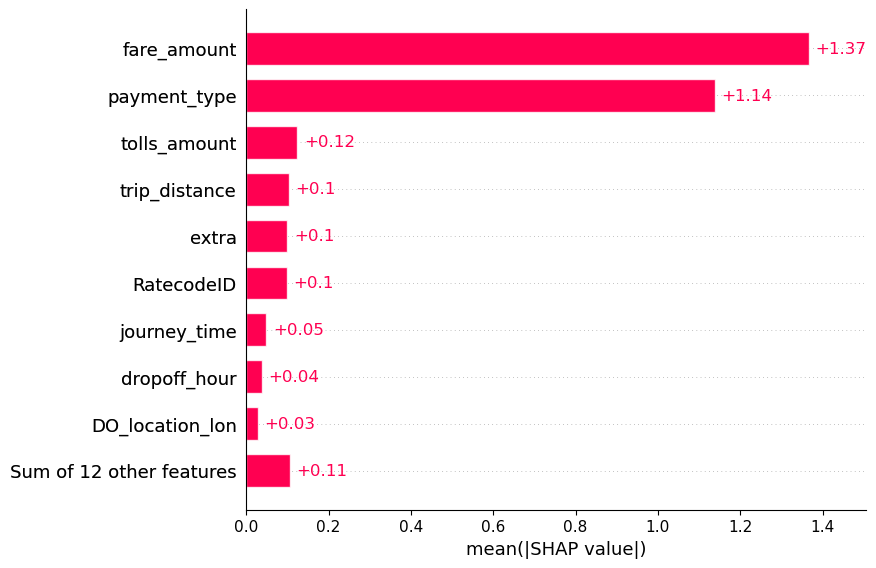

In [23]:
#
shap_values = explainer(X_test)


shap.plots.bar(shap_values)




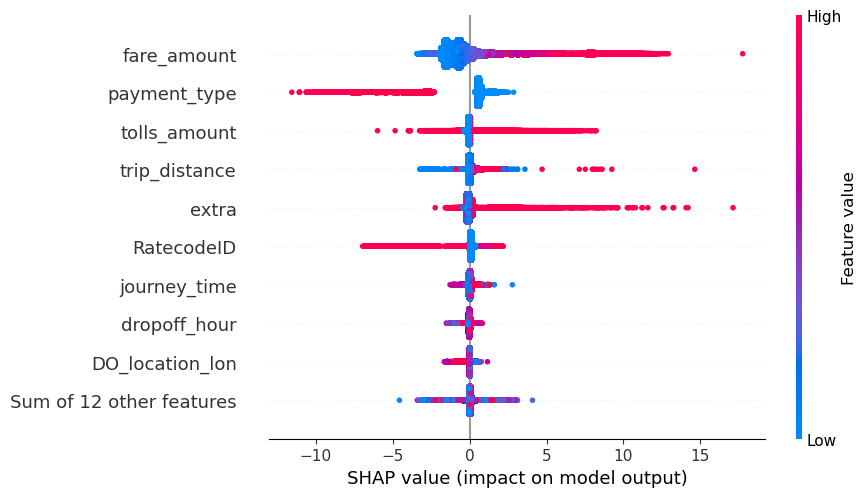

In [24]:
import shap
import matplotlib.pyplot as plt

shap.plots.beeswarm(shap_values)


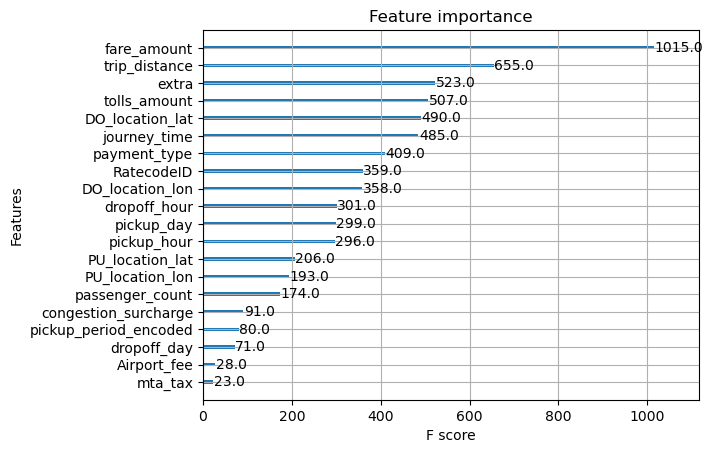

In [26]:


from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
plot_importance(best_xgb_model)
plt.show()
